In [ ]:
# data collection using PRAW reddit api
import praw
import pandas as pd
import time
import datetime


SUBREDDIT_NAME = "climatechange"
LIMIT = 100  # Number of top posts to fetch
OUTPUT_FILE = "reddit_climate_data.csv"

# ===============================================
# 1. Initialize PRAW
# ===============================================

reddit = praw.Reddit(
    client_id="put yours",
    client_secret="put yours",
    user_agent="put yours"
)

# ===============================================
# 2. Data Collection Function
# ===============================================

def get_reddit_data(subreddit_name, limit):
    """Fetches posts and all comments from a subreddit."""
    data = []
    subreddit = reddit.subreddit(subreddit_name)

    # Fetch submissions (posts) - using 'top' for good coverage, 'new' for recent data
    print(f"Fetching {limit} posts from r/{subreddit_name}...")
    
    for submission in subreddit.new(limit=limit):
        
        # --- A. Extract Post Data ---
        print(f"-> Processing Post: {submission.title[:50]}... ({submission.id})")
        data.append({
            'type': 'post',
            'id': submission.id,
            'parent_id': None, # Posts are top-level
            'post_title': submission.title,
            'text': submission.selftext,
            'author': submission.author.name if submission.author else '[deleted]',
            'score': submission.score,
            'timestamp_utc': submission.created_utc,
            'url': submission.url,
            'permalink': f"https://www.reddit.com{submission.permalink}"
        })

        # --- B. Extract Comments ---
        # Resolve 'MoreComments' links to get all comments
        submission.comments.replace_more(limit=None) 
        
        # Iterate over all comments, including replies (flat list)
        for comment in submission.comments.list():
            if comment.author is None:
                author_name = '[deleted]'
            elif comment.author.name == 'AutoModerator':
                # Skip the bot's comment
                continue
            else:
                author_name = comment.author.name
            
            # parent_id starts with 't3_' for the post or 't1_' for another comment
            parent_id = comment.parent_id
            
            data.append({
                'type': 'comment',
                'id': comment.id,
                'parent_id': parent_id,
                'post_title': submission.title, # Keep the post title for context
                'text': comment.body,
                'author': author_name,
                'score': comment.score,
                'timestamp_utc': comment.created_utc,
                'url': None,
                'permalink': f"https://www.reddit.com{comment.permalink}"
            })
            
        print(f"<- Finished comments for post {submission.id}. Total entries: {len(data)}")
        # Introduce a small delay to respect Reddit's rate limits
        time.sleep(1)

    return pd.DataFrame(data)


# ===============================================
# 3. Run and Save Data
# ===============================================

if __name__ == "__main__":
    df = get_reddit_data(SUBREDDIT_NAME, LIMIT)
    
    # Convert Unix timestamp to readable date/time
    df['date'] = pd.to_datetime(df['timestamp_utc'], unit='s')
    
    # Reorder columns for readability
    df = df[[
        'type', 'id', 'parent_id', 'post_title', 'text', 'author', 
        'score', 'timestamp_utc', 'date', 'permalink'
    ]]
    
    # Save to CSV
    df.to_csv(OUTPUT_FILE, index=False)
    
    print("\n==============================================")
    print(f"Data Collection Complete!")
    print(f"Total rows (Posts + Comments): {len(df)}")
    print(f"File saved to: {OUTPUT_FILE}")
    print("==============================================")

In [ ]:
from google.colab import files
import os

# Define the file name used in the scraping script
FILE_NAME = "reddit_climate_data.csv"

# Check if the file exists before attempting to download
if os.path.exists(FILE_NAME):
    files.download(FILE_NAME)
    print(f"\n✅ Successfully started download of {FILE_NAME} to your local machine.")
else:
    print(f"\n❌ Error: The file '{FILE_NAME}' was not found. Please ensure your scraping script ran successfully.")

In [2]:
# Install required libraries
!pip install nltk scikit-learn

# Download all necessary NLTK resources (WordNet is needed for Lemmatization)
import nltk
print("Downloading NLTK resources...")
# 👇 This line fixes your error
nltk.download('wordnet') 
nltk.download('punkt')
nltk.download('stopwords')

import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Define the file name
FILE_NAME = "reddit_climate_data.csv"

print(f"\n✅ Setup complete. Ready to process file: {FILE_NAME}")


✅ Setup complete. Ready to process file: reddit_climate_data.csv



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# --- 2.1. Text Pre-processing ---

# Load the dataset
try:
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"Error: {FILE_NAME} not found. Ensure the scraping code ran correctly.")
    exit()

# Combine post text and comment text into a single content series. 
# We filter out rows where 'text' is empty or [deleted] which often happens 
# with deleted selftext posts or deleted comments.
corpus = df[df['text'].str.strip() != ''].copy()
corpus['text'] = corpus['text'].astype(str)

# Initialize Lemmatizer and Stop Words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add specific words often found in Reddit data to the stop word list
reddit_specific_stops = ['amp', 'https', 'www', 'com', 'reddit', 'post', 'comment', 'deleted']
stop_words.update(reddit_specific_stops)

def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # 4. Tokenization and Stop Word Removal
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]
    
    # 5. Lemmatization (using WordNet)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(lemmatized_tokens)

# Apply pre-processing to the content
print("Starting text pre-processing...")
corpus['clean_text'] = corpus['text'].apply(preprocess_text)
print("Text pre-processing complete.")
print(f"Total documents (posts/comments) for TF-IDF: {len(corpus)}")

Starting text pre-processing...
Text pre-processing complete.
Total documents (posts/comments) for TF-IDF: 4702


In [4]:
# --- 2.2. Calculate TF-IDF ---

# Use scikit-learn's TfidfVectorizer
# min_df=5: Ignores terms that appear in less than 5 documents (to filter noise)
# max_df=0.85: Ignores terms that appear in more than 85% of documents (to filter overly common words)
vectorizer = TfidfVectorizer(min_df=5, max_df=0.85, ngram_range=(1, 2))

# Fit the vectorizer to the clean text and transform the data
tfidf_matrix = vectorizer.fit_transform(corpus['clean_text'])
feature_names = np.array(vectorizer.get_feature_names_out())

# Calculate the average TF-IDF score for each term across the entire corpus
# 1. Sum the TF-IDF scores for each term (column)
term_sum_tfidf = np.sum(tfidf_matrix, axis=0).A1

# 2. Pair term names with their summed TF-IDF score
tfidf_scores = pd.Series(term_sum_tfidf, index=feature_names)

# --- 2.3. Identify Key Topics ---

# Sort the terms to find the top terms
TOP_N = 100
top_terms = tfidf_scores.nlargest(TOP_N)

print("\n=======================================================")
print(f"Top {TOP_N} Key Terms by Aggregated TF-IDF Score")
print("=======================================================")
for term, score in top_terms.items():
    print(f"{term:<30} | Score: {score:.4f}")

# Save the top terms for the report
top_terms.to_csv("top_tfidf_terms.csv", header=['TFIDF_Score'])
print("\nTop terms saved to 'top_tfidf_terms.csv'")


Top 100 Key Terms by Aggregated TF-IDF Score
climate                        | Score: 103.2470
year                           | Score: 99.6301
change                         | Score: 96.3614
removed                        | Score: 92.8034
people                         | Score: 72.6696
like                           | Score: 65.2499
climate change                 | Score: 63.4513
would                          | Score: 60.0885
one                            | Score: 58.6056
human                          | Score: 53.0843
think                          | Score: 52.6905
much                           | Score: 52.1593
time                           | Score: 51.4225
nan                            | Score: 50.0000
even                           | Score: 47.8970
know                           | Score: 44.7148
global                         | Score: 43.4943
thing                          | Score: 43.4393
make                           | Score: 43.1079
earth                          | Score: 4

In [5]:
# --- 2.4. Analyze Relevance ---

# Get the list of the top 100 high-relevance terms
high_relevance_terms = set(top_terms.index)

def calculate_relevance_score(clean_text, relevance_terms):
    """Calculates a score based on the count of high-relevance terms in the text."""
    if not clean_text:
        return 0
    
    tokens = clean_text.split()
    score = 0
    
    # Check for single words and 2-word phrases (ngrams)
    for i in range(len(tokens)):
        # Check single word
        if tokens[i] in relevance_terms:
            score += 1
        
        # Check bigrams
        if i < len(tokens) - 1:
            bigram = f"{tokens[i]} {tokens[i+1]}"
            if bigram in relevance_terms:
                score += 1 # Count the bigram as a single hit

    return score

# Apply the scoring function
corpus['relevance_score'] = corpus['clean_text'].apply(
    lambda x: calculate_relevance_score(x, high_relevance_terms)
)

# Display the 10 most relevant documents
most_relevant_documents = corpus.sort_values(by='relevance_score', ascending=False).head(10)

print("\n=======================================================")
print("Top 10 Most Relevant Documents (Posts/Comments) by Score")
print("=======================================================")

for index, row in most_relevant_documents.iterrows():
    print(f"Type: {row['type'].upper()} | Score: {row['relevance_score']} | ID: {row['id']}")
    print(f"Title: {row['post_title'][:50]}...")
    print(f"Text Snippet: {row['text'][:100]}...")
    print("-" * 50)

# Save the corpus with the new score for further analysis
corpus[['type', 'id', 'post_title', 'text', 'clean_text', 'relevance_score']].to_csv(
    "reddit_relevance_analyzed.csv", index=False
)
print("\nDetailed relevance analysis saved to 'reddit_relevance_analyzed.csv'")


Top 10 Most Relevant Documents (Posts/Comments) by Score
Type: COMMENT | Score: 205 | ID: nhmaf48
Title: How much of global warming is actually caused by h...
Text Snippet: **NOAA Climate\.gov** — [What evidence exists that Earth is warming and that humans are the main cau...
--------------------------------------------------
Type: COMMENT | Score: 163 | ID: nh2cl6t
Title: How much of global warming is actually caused by h...
Text Snippet: Climate changes for a reason. 

Scientists have measured warming, this is a fact. A rise in temperat...
--------------------------------------------------
Type: COMMENT | Score: 122 | ID: ng0axt7
Title: Study finds sticking to Paris agreement could actu...
Text Snippet: # Study finds sticking to Paris agreement could actually improve economic growth, while severe clima...
--------------------------------------------------
Type: COMMENT | Score: 115 | ID: nh0a7yz
Title: How much of global warming is actually caused by h...
Text Snippet: Shame on all 

In [6]:
# Install required libraries for graph analysis
!pip install networkx tldextract

import pandas as pd
import re
import networkx as nx
import tldextract
import matplotlib.pyplot as plt
import numpy as np

# Load the previously processed data (assuming it's named 'reddit_climate_data.csv')
FILE_NAME = "reddit_climate_data.csv"
try:
    df = pd.read_csv(FILE_NAME).fillna({'text': ''})
except FileNotFoundError:
    print(f"Error: {FILE_NAME} not found. Please ensure it is in the same folder.")
    exit()

print(f"Loaded {len(df)} rows for Link Structure Analysis.")


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Loaded 4702 rows for Link Structure Analysis.



Top 20 External Domains Linked in r/climatechange
wikipedia.org                  | Links: 48
nature.com                     | Links: 31
nasa.gov                       | Links: 30
noaa.gov                       | Links: 26
ipcc.ch                        | Links: 24
ourworldindata.org             | Links: 23
science.org                    | Links: 21
xkcd.com                       | Links: 15
europa.eu                      | Links: 12
doi.org                        | Links: 11
youtu.be                       | Links: 11
sciencedirect.com              | Links: 10
carbonbrief.org                | Links: 10
climatechangetracker.org       | Links: 9
wiley.com                      | Links: 7
nih.gov                        | Links: 7
drawdown.org                   | Links: 6
chatgpt.com                    | Links: 6
youtube.com                    | Links: 6
co2levels.org                  | Links: 6


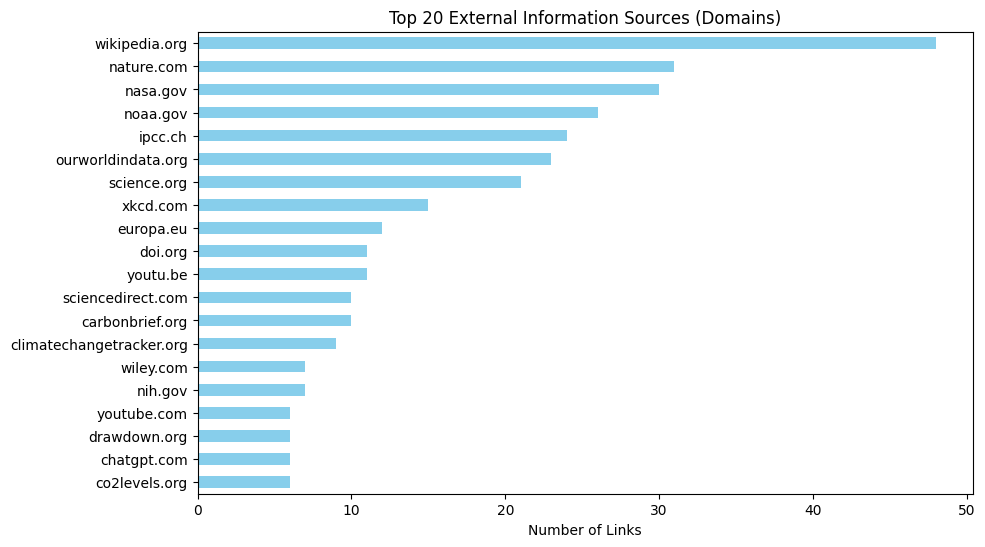

In [7]:
# --- 3.1. External Link Analysis ---

# Regular expression to find all URLs in the text
URL_REGEX = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

all_urls = []

# Iterate through all posts and comments to extract URLs
for text in df['text']:
    urls = re.findall(URL_REGEX, str(text))
    all_urls.extend(urls)

# Extract domains using tldextract for accurate primary domain identification
domains = []
for url in all_urls:
    extracted = tldextract.extract(url)
    # Filter out common Reddit internal links
    if extracted.domain not in ['reddit', 'redd']:
        domains.append(f"{extracted.domain}.{extracted.suffix}")

# Count the frequency of each domain
domain_counts = pd.Series(domains).value_counts().head(20)

print("\n=======================================================")
print("Top 20 External Domains Linked in r/climatechange")
print("=======================================================")
for domain, count in domain_counts.items():
    print(f"{domain:<30} | Links: {count}")

# Optional: Plotting the top domains
plt.figure(figsize=(10, 6))
domain_counts.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 20 External Information Sources (Domains)')
plt.xlabel('Number of Links')
plt.show()

In [8]:


# --- 3.2. Comment/Reply Graph Analysis  ---

# Filter for comments only, as they have a 'parent_id'
comments_df = df[df['type'] == 'comment'].copy()

#  Create a function to strip Reddit prefixes ('t1_', 't3_')
def normalize_id(reddit_id):
    if pd.isna(reddit_id):
        return None
    # Strip common prefixes for standardization
    if isinstance(reddit_id, str):
        return reddit_id.split('_')[-1]
    return reddit_id

# Apply the normalization to the ID and Parent ID columns
comments_df['child_id_clean'] = comments_df['id'].apply(normalize_id)
comments_df['parent_id_clean'] = comments_df['parent_id'].apply(normalize_id)

# Create a directed graph
ReplyGraph = nx.DiGraph()

# Add edges: (Child Comment ID) -> (Parent ID)
for _, row in comments_df.iterrows():
    child_node = row['child_id_clean']    # The current comment (stripped ID)
    parent_node = row['parent_id_clean']  # The post or comment it replies to (stripped ID)
    
    # Only add the edge if both parent and child IDs are valid and different
    if pd.notna(child_node) and pd.notna(parent_node) and child_node != parent_node:
        ReplyGraph.add_edge(child_node, parent_node)

print(f"Reply/Comment Graph Created with {ReplyGraph.number_of_nodes()} nodes and {ReplyGraph.number_of_edges()} edges.")

# Calculate In-Degree Centrality: how many replies a node (comment/post) receives
in_degree = ReplyGraph.in_degree()
# Note: The IDs in this DataFrame are now the CLEAN IDs
in_degree_df = pd.DataFrame(in_degree, columns=['clean_id', 'in_degree']).set_index('clean_id')

# Prepare original dataframe for merging by cleaning its ID first
df_temp = df.copy()
df_temp['clean_id'] = df_temp['id'].apply(normalize_id)

# Merge centrality score back into the original dataframe for context
df_with_centrality = df_temp.set_index('clean_id').join(in_degree_df).fillna({'in_degree': 0})

# Identify the Top 10 most replied-to submissions/comments (highest In-Degree)
top_replied_to = df_with_centrality.sort_values(by='in_degree', ascending=False).head(10)

print("\n=======================================================")
print("Top 10 Central Nodes (Most Replied-To Posts/Comments)")
print("=======================================================")
for index, row in top_replied_to.iterrows():
    print(f"Type: {row['type'].upper():<7} | Replies (In-Degree): {int(row['in_degree']):<5} | ID: {row['id']}")
    print(f"Title: {row['post_title'][:50]}...")
    print(f"Text Snippet: {row['text'][:80]}...")
    print("-" * 50)

Reply/Comment Graph Created with 4684 nodes and 4602 edges.

Top 10 Central Nodes (Most Replied-To Posts/Comments)
Type: POST    | Replies (In-Degree): 244   | ID: 1nt58pw
Title: How much of global warming is actually caused by h...
Text Snippet: My school (private Christian, using BJU Press) says that most of it is not human...
--------------------------------------------------
Type: POST    | Replies (In-Degree): 168   | ID: 1npq1uf
Title: Please help me convince my father climate change i...
Text Snippet: Hey everyone, I recently had a heated discussion with my MAGA father about how h...
--------------------------------------------------
Type: POST    | Replies (In-Degree): 144   | ID: 1nt7bey
Title: How long realistically till global warning will ta...
Text Snippet: ...
--------------------------------------------------
Type: POST    | Replies (In-Degree): 121   | ID: 1norf6y
Title: Suppose it’s 2050 and very little has been done ab...
Text Snippet: Let’s say: Status quo climate po

In [9]:


# --- 3.3. User Interaction Graph (CORRECTED) ---

# Re-defining normalize_id for robustness, in case you run this cell independently
def normalize_id(reddit_id):
    if pd.isna(reddit_id):
        return None
    if isinstance(reddit_id, str):
        # Strip common prefixes for standardization
        return reddit_id.split('_')[-1]
    return reddit_id

# Prepare data and mappings:
interaction_df = df[df['type'] == 'comment'].copy()
interaction_df = interaction_df[interaction_df['author'] != '[deleted]'].copy()

# Create a mapping from CLEAN ID to Author name
# This ensures that both post and comment IDs are stripped of t1_/t3_ before becoming keys
df_temp_map = df.copy()
df_temp_map['clean_id'] = df_temp_map['id'].apply(normalize_id)
id_to_author = df_temp_map.set_index('clean_id')['author'].to_dict()

# Create a directed graph where nodes are unique authors
UserGraph = nx.DiGraph()

# Add edges representing a reply: (Author of Child) -> (Author of Parent)
for _, row in interaction_df.iterrows():
    child_author = row['author']
    raw_parent_id = row['parent_id']

    #  Normalize the parent_id before looking up the parent author
    # This is critical because the 'parent_id' is raw (e.g., 't3_xyz'), but the map keys are clean (e.g., 'xyz')
    clean_parent_id = normalize_id(raw_parent_id)
    
    # Look up the author of the parent item using the clean ID
    parent_author = id_to_author.get(clean_parent_id)

    # Ensure both authors are valid and not the same user (self-reply)
    if (child_author and parent_author and 
        child_author != '[deleted]' and parent_author != '[deleted]' and 
        child_author != parent_author):
        
        # An edge exists from the user who made the reply (child_author) 
        # to the user who received the reply (parent_author).
        # Both nodes are Author names, so no ID normalization is needed here.
        UserGraph.add_edge(child_author, parent_author)

print(f"User Interaction Graph Created with {UserGraph.number_of_nodes()} users and {UserGraph.number_of_edges()} interactions.")

# --- Analyze User Centrality Metrics ---

# 1. Degree Centrality (most direct connections)
# Users with high degree centrality are those who participate the most, both initiating and receiving replies.
degree_centrality = nx.degree_centrality(UserGraph)
degree_centrality_series = pd.Series(degree_centrality).sort_values(ascending=False).head(10)

# 2. Betweenness Centrality (users who act as "bridges" between groups)
# These users connect distinct conversation clusters.
betweenness_centrality = nx.betweenness_centrality(UserGraph)
betweenness_centrality_series = pd.Series(betweenness_centrality).sort_values(ascending=False).head(10)

print("\n=======================================================")
print("Top 10 Most Influential Users (Degree Centrality)")
print("=======================================================")
for user, score in degree_centrality_series.items():
    print(f"User: {user:<25} | Degree Centrality: {score:.6f}")

print("\n=======================================================")
print("Top 10 Users as 'Bridges' (Betweenness Centrality)")
print("=======================================================")
for user, score in betweenness_centrality_series.items():
    print(f"User: {user:<25} | Betweenness Centrality: {score:.6f}")

User Interaction Graph Created with 1653 users and 3183 interactions.

Top 10 Most Influential Users (Degree Centrality)
User: Igotbannedagainhehe       | Degree Centrality: 0.185230
User: Economy-Fee5830           | Degree Centrality: 0.127119
User: StarWatcher68             | Degree Centrality: 0.101695
User: Infamous_Employer_85      | Degree Centrality: 0.093826
User: MedicineAmazing6207       | Degree Centrality: 0.085351
User: _social_disease_          | Degree Centrality: 0.070218
User: Good_Run_1696             | Degree Centrality: 0.067191
User: SickMeter                 | Degree Centrality: 0.061743
User: DanoPinyon                | Degree Centrality: 0.058111
User: Molire                    | Degree Centrality: 0.036320

Top 10 Users as 'Bridges' (Betweenness Centrality)
User: Economy-Fee5830           | Betweenness Centrality: 0.129075
User: Igotbannedagainhehe       | Betweenness Centrality: 0.104081
User: Infamous_Employer_85      | Betweenness Centrality: 0.077307
User: 

Plotting subgraph of the top 29 most replied-to nodes.


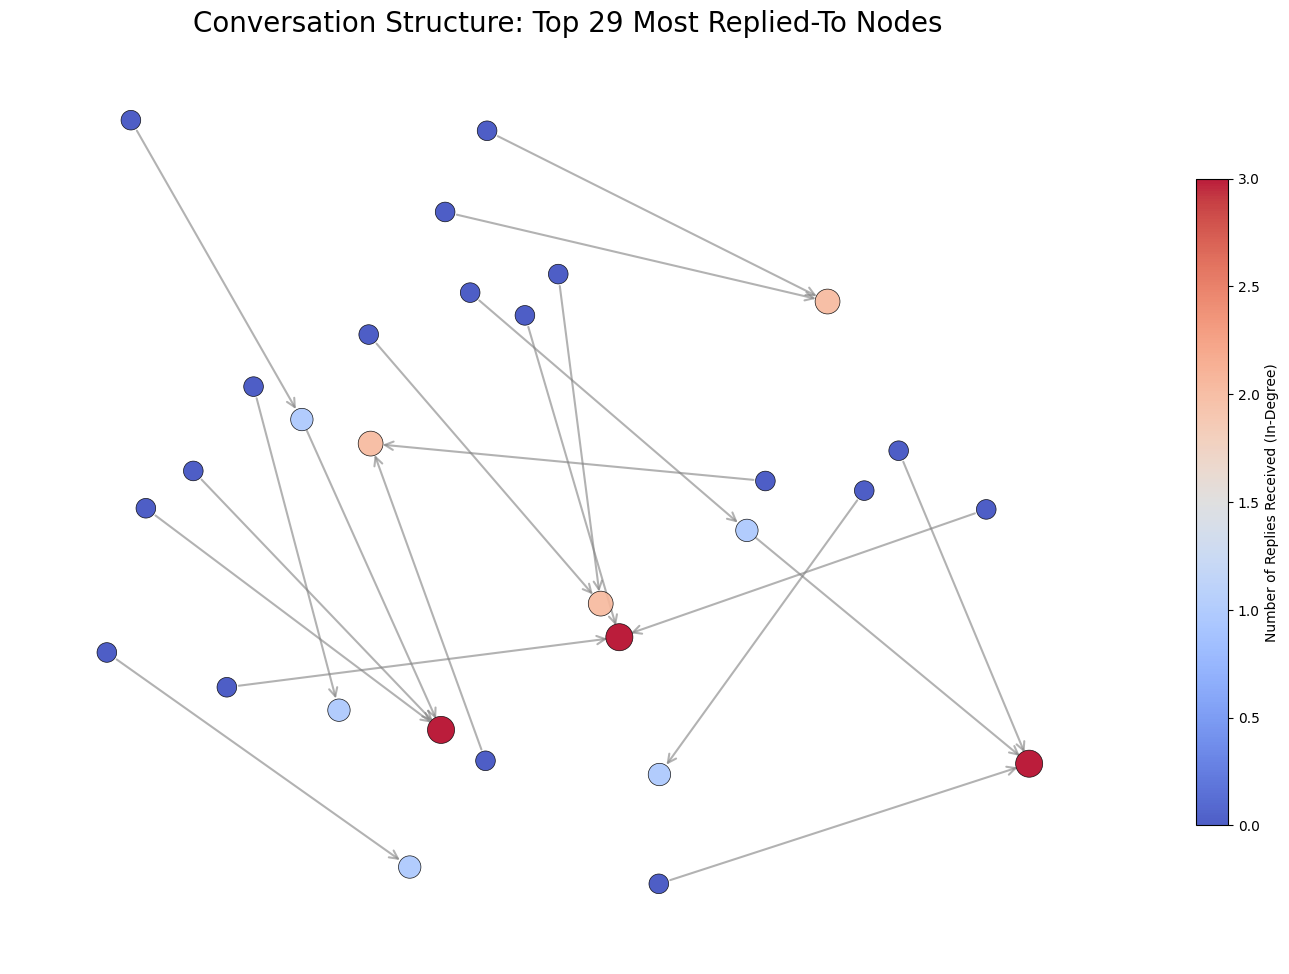

In [10]:

import matplotlib.pyplot as plt
import networkx as nx

# --- 3.2 Visualization: Comment/Reply Graph (Improved Layout) ---

if 'ReplyGraph' not in locals():
    print("Error: ReplyGraph not found. Please run Cell 7 first.")
else:
    # 1. Select a clear subgraph: Top N most-replied-to nodes
    MAX_NODES = 75 
    
    all_in_degrees = dict(ReplyGraph.in_degree())
    top_nodes = sorted(all_in_degrees, key=all_in_degrees.get, reverse=True)[:MAX_NODES]
    
    # Explicitly create a mutable copy (nx.DiGraph) of the subgraph view
    subgraph = nx.DiGraph(ReplyGraph.subgraph(top_nodes))
    subgraph.remove_nodes_from(list(nx.isolates(subgraph)))

    print(f"Plotting subgraph of the top {len(subgraph.nodes())} most replied-to nodes.")


    plt.figure(figsize=(18, 12))

    # --- Layout and Styling ---
    pos = nx.kamada_kawai_layout(subgraph) 

    node_sizes = [subgraph.in_degree(node) * 60 + 200 for node in subgraph.nodes()]
    node_colors = [subgraph.in_degree(node) for node in subgraph.nodes()]

    # Draw nodes and CAPTURE the object returned by the function
    nodes = nx.draw_networkx_nodes(
        subgraph, 
        pos, 
        node_size=node_sizes, 
        node_color=node_colors, 
        cmap=plt.cm.coolwarm, 
        alpha=0.9,
        edgecolors='black',
        linewidths=0.5
    )
    
    # Draw edges
    nx.draw_networkx_edges(
        subgraph, 
        pos, 
        arrowstyle='->', 
        arrowsize=15, 
        edge_color='gray',
        alpha=0.6,
        width=1.5
    )
    
    #  Pass the 'nodes' object directly to the colorbar function
    if nodes is not None:
        cbar = plt.colorbar(nodes, shrink=0.7)
        cbar.set_label('Number of Replies Received (In-Degree)')

    plt.title(f"Conversation Structure: Top {len(subgraph.nodes())} Most Replied-To Nodes", fontsize=20)
    plt.axis('off')
    plt.show()

Plotting influential subgraph with 50 users and 171 interactions.


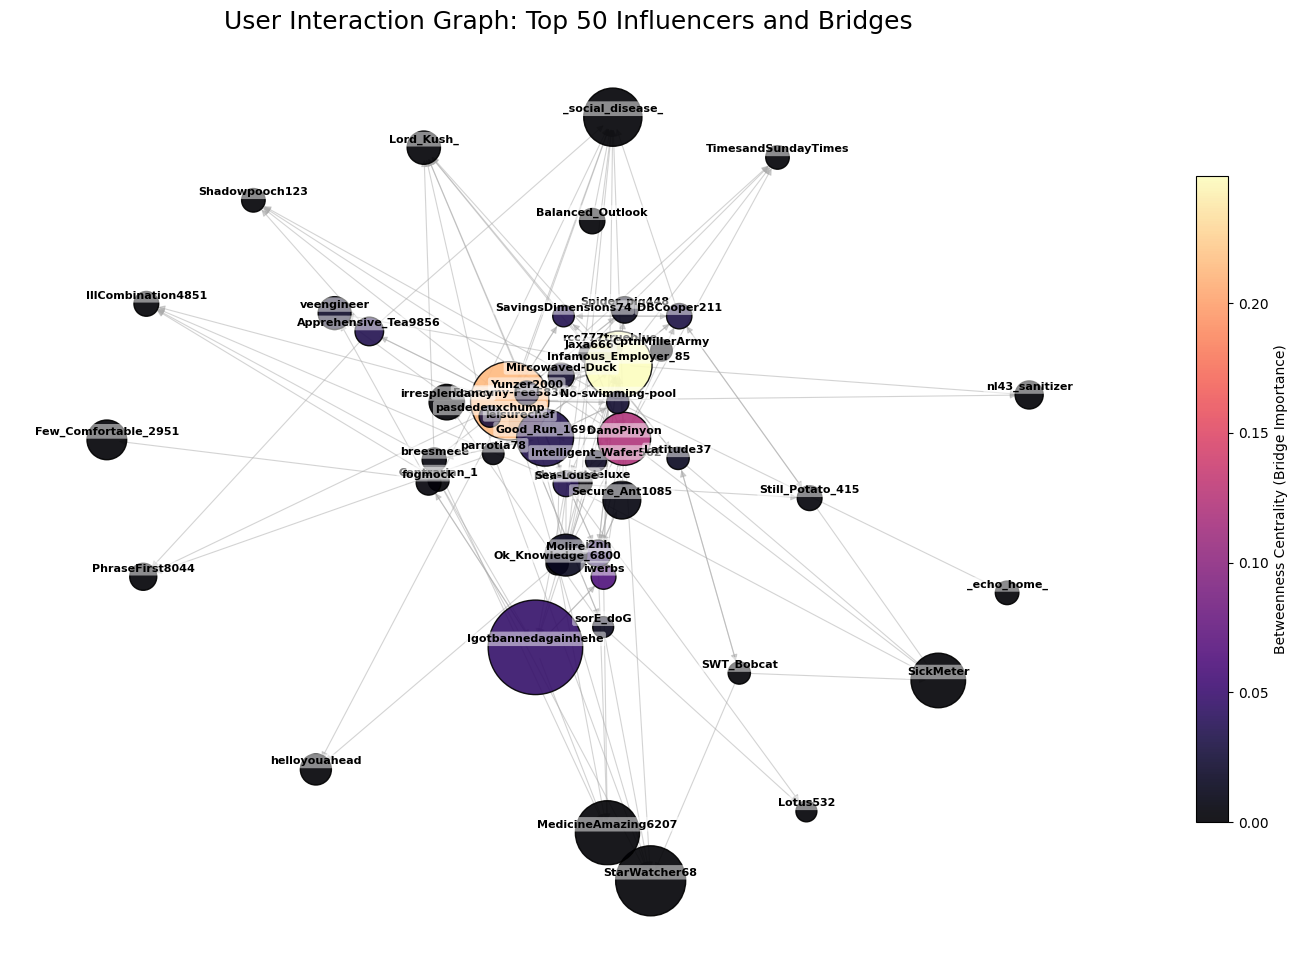

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# --- 3.3 Visualization: User Interaction Graph (Improved Layout) ---

if 'UserGraph' not in locals() or 'degree_centrality' not in locals():
    print("Error: UserGraph or degree_centrality not found. Please run Cell 8 first.")
else:
    # 1. Select the top 50 users by Degree Centrality
    TOP_USERS_COUNT = 50
    degree_series = pd.Series(degree_centrality).sort_values(ascending=False)
    top_user_names = degree_series.index[:TOP_USERS_COUNT].tolist()

    # 2. Create the subgraph of only these top users (mutable copy)
    influencer_subgraph = nx.DiGraph(UserGraph.subgraph(top_user_names))
    influencer_subgraph.remove_nodes_from(list(nx.isolates(influencer_subgraph)))

    print(f"Plotting influential subgraph with {len(influencer_subgraph.nodes())} users and {influencer_subgraph.number_of_edges()} interactions.")

    plt.figure(figsize=(18, 12))

    # --- Layout and Styling ---
    pos = nx.fruchterman_reingold_layout(influencer_subgraph, k=0.15, iterations=50) 

    node_sizes = [degree_centrality[user] * 25000 for user in influencer_subgraph.nodes()]
    betweenness_scores = nx.betweenness_centrality(influencer_subgraph)
    node_colors = [betweenness_scores[user] for user in influencer_subgraph.nodes()]

    # Draw nodes and CAPTURE the object returned by the function
    nodes = nx.draw_networkx_nodes(
        influencer_subgraph, 
        pos, 
        node_size=node_sizes, 
        node_color=node_colors, 
        cmap=plt.cm.magma, 
        alpha=0.9,
        edgecolors='black',
        linewidths=1.0
    )
    
    # Draw edges
    nx.draw_networkx_edges(
        influencer_subgraph, 
        pos, 
        edge_color='darkgray',
        alpha=0.5,
        width=0.8
    )

    # Draw labels
    labels = {user: user for user in influencer_subgraph.nodes()}
    label_pos = {k: [v[0], v[1] + 0.02] for k, v in pos.items()} 
    
    nx.draw_networkx_labels(
        influencer_subgraph, 
        label_pos, 
        labels=labels, 
        font_size=8, 
        font_weight='bold', 
        font_color='black',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2') 
    )
    
    # Pass the 'nodes' object directly to the colorbar function
    if nodes is not None:
        cbar = plt.colorbar(nodes, shrink=0.7)
        cbar.set_label('Betweenness Centrality (Bridge Importance)')

    plt.title(f"User Interaction Graph: Top {TOP_USERS_COUNT} Influencers and Bridges", fontsize=18)
    plt.axis('off')
    plt.show()

Building co-occurrence graph for the top 50 TF-IDF terms...
Co-occurrence Graph Created with 48 terms and 1107 co-occurrences.


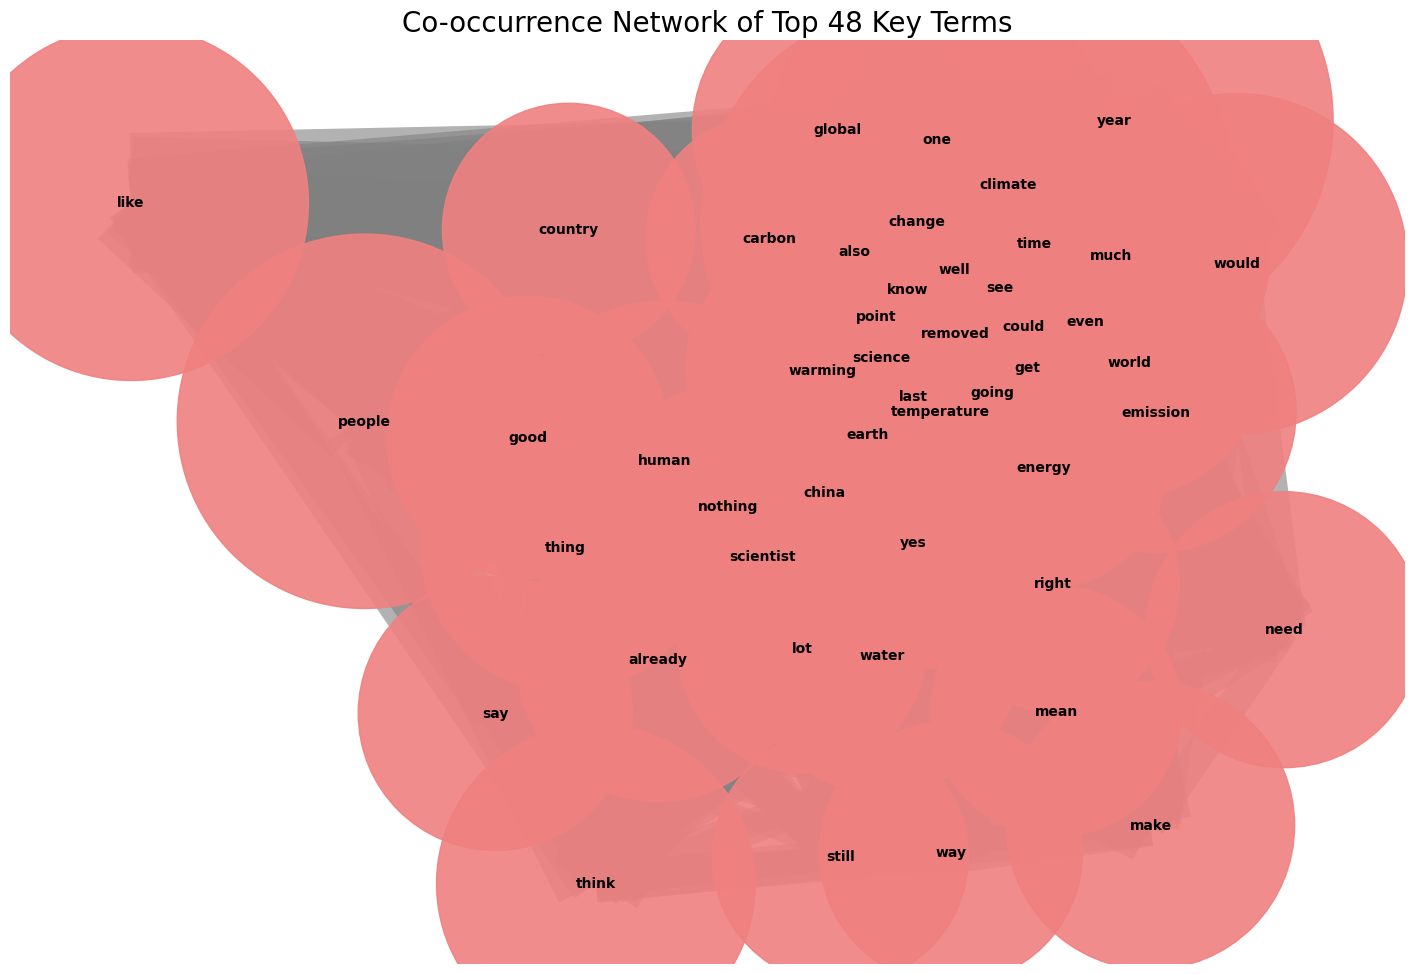

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import itertools

# --- 3.4. Top Term Co-occurrence Graph ---

# Ensure required variables from previous cells are available
if 'corpus' not in locals():
    print("Error: DataFrame 'corpus' (with clean_text) not found. Please run Cell 2 first.")
    exit()
if 'top_terms' not in locals():
    print("Error: Top TF-IDF terms not found. Please run Cell 3 first.")
    exit()

# 1. Define the terms to include in the graph
TOP_TERMS_FOR_GRAPH = 50
term_list = set(top_terms.index[:TOP_TERMS_FOR_GRAPH].tolist())

print(f"Building co-occurrence graph for the top {TOP_TERMS_FOR_GRAPH} TF-IDF terms...")

# 2. Build the Co-occurrence Edge List
co_occurrence_counts = Counter()

# Iterate through every document (post/comment) in the corpus
for clean_text in corpus['clean_text']:
    if pd.isna(clean_text) or not clean_text:
        continue
    
    # Get the unique high-relevance terms present in this document
    present_terms = [word for word in clean_text.split() if word in term_list]
    
    # Generate all unique pairs of terms in that document (co-occurrence)
    # The combination function handles pairs (A, B) and (B, A) only once.
    if len(present_terms) >= 2:
        for term1, term2 in itertools.combinations(sorted(list(set(present_terms))), 2):
            co_occurrence_counts[(term1, term2)] += 1

# 3. Create the NetworkX Graph
CoOccurrenceGraph = nx.Graph()

MIN_CO_OCCURRENCE = 3 # Only include edges if terms appear together at least 3 times

# Add nodes and weighted edges
for (term1, term2), weight in co_occurrence_counts.items():
    if weight >= MIN_CO_OCCURRENCE:
        CoOccurrenceGraph.add_edge(term1, term2, weight=weight)

# Remove nodes that were isolated after filtering by MIN_CO_OCCURRENCE
CoOccurrenceGraph.remove_nodes_from(list(nx.isolates(CoOccurrenceGraph)))

print(f"Co-occurrence Graph Created with {CoOccurrenceGraph.number_of_nodes()} terms and {CoOccurrenceGraph.number_of_edges()} co-occurrences.")

# 4. Visualization
plt.figure(figsize=(18, 12))

# Use the weight of the edges to determine thickness
edge_widths = [d['weight'] * 0.5 for (u, v, d) in CoOccurrenceGraph.edges(data=True)]

# Use Kamada-Kawai layout for better term separation
pos = nx.kamada_kawai_layout(CoOccurrenceGraph) 

# --- Draw Nodes ---
# Node Size: Scale by the term's original TF-IDF score (from Cell 3)
node_sizes = [top_terms[node] * 1000 for node in CoOccurrenceGraph.nodes()]

nodes = nx.draw_networkx_nodes(
    CoOccurrenceGraph,
    pos,
    node_size=node_sizes,
    node_color='lightcoral',
    alpha=0.9
)

# --- Draw Edges ---
nx.draw_networkx_edges(
    CoOccurrenceGraph,
    pos,
    width=edge_widths,
    edge_color='gray',
    alpha=0.6
)

# --- Draw Labels ---
nx.draw_networkx_labels(
    CoOccurrenceGraph,
    pos,
    font_size=10,
    font_weight='bold'
)

plt.title(f"Co-occurrence Network of Top {CoOccurrenceGraph.number_of_nodes()} Key Terms", fontsize=20)
plt.axis('off')
plt.show()